In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon

import geopandas

In [3]:
dir_data = 'data/biximontrealrentals2019-33ea73/'
df_stations = pd.read_csv(dir_data+'Stations_2019.csv')


In [4]:
df_stations

,Code,name,latitude,longitude
0,10002,Métro Charlevoix (Centre / Charlevoix),45.478228,-73.569651
1,4000,Jeanne-d'Arc / Ontario,45.549598,-73.541874
2,4001,Graham / Brookfield,45.520075,-73.629776
3,4002,Graham / Wicksteed,45.516937,-73.640483
4,5002,St-Charles / Montarville,45.533682,-73.515261
...,...,...,...,...
614,7149,16e avenue / Jean-Talon,45.562440,-73.595333
615,7150,du Souvenir / Chomedey,45.551886,-73.744440
616,7151,Métro Montmorency (de l'Avenir / Jacques-Tétre...,45.558109,-73.719597
617,7152,Parc St-Claude (7e avenue / 8e rue),45.562668,-73.692362


In [14]:
mtl_map = geopandas.read_file('data/limadmin-shp/LIMADMIN.shp')

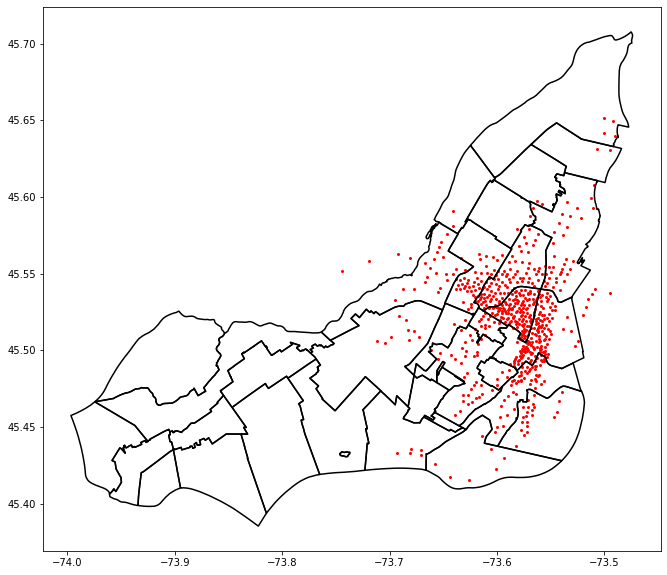

In [39]:
fig, ax = plt.subplots(1, sharex=True, figsize=(15,10))
mtl_map.boundary.plot(ax=ax, edgecolor='black')

# designate coordinate system
crs='EPSG:4326'
# zip x and y coordinates into single feature
geometry = [Point(xy) for xy in zip(df_stations['longitude'], df_stations['latitude'])]
# create GeoPandas dataframe
geo_df = geopandas.GeoDataFrame(df_stations,
 crs = crs,
 geometry = geometry)


geo_df.plot(ax=ax, color='red', markersize=4)

